In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import json
from tqdm.notebook import tqdm

from scipy.optimize import minimize
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates

import plotly.express as px
import plotly

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

C:\Users\User\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\User\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
with open('config/config.json', 'r') as file:
    config = json.load(file)

# Loading data

In [3]:
df_clusters = pd.read_csv(config['predictions_path'])
df_clusters.columns = ['ticker'] + df_clusters.columns.tolist()[1:]
df_clusters.head()

ticker           original  original_n  \
0      A         Healthcare           6   
1    AAL        Industrials           7   
2    AAP  Consumer Cyclical           2   
3   AAPL         Technology           9   
4   ABBV         Healthcare           6   

   original;;|Kmeans;algorithm:auto,init:k-means++,n_clusters:9  \
0                                                  8              
1                                                  2              
2                                                  1              
3                                                  8              
4                                                  0              

   original;;|Birch;branching_factor:10,n_clusters:9  \
0                                                  3   
1                                                  0   
2                                                  3   
3                                                  3   
4                                                  3   

   original;;|Agglomer;linkage:ward,n_clusters:9  \
0                                              6   
1                                              1   
2                                              2   
3                                              6   
4                                              2   

   original;;|MiniBatchKMeans;init:k-means++,n_clusters:9  \
0                                                  1        
1                                                  5        
2                                                  4        
3                                                  1        
4                                                  3        

   original;;|Gauss_Mix;covariance_type:full,init_params:kmeans,n_components:9  \
0                                                  0                             
1                                                  7                             
2                                                  3                             
3                                                  2                             
4                                                  0                             

   original;;|Spectral;eigen_solver:arpack,n_clusters:9  \
0                                                  2      
1                                                  6      
2                                                  3      
3                                                  2      
4                                                  1      

   table_data;;|Kmeans;algorithm:auto,init:k-means++,n_clusters:9  \
0                                                  0                
1                                                  3                
2                                                  2                
3                                                  0                
4                                                  1                

   table_data;;|Birch;branching_factor:10,n_clusters:9  \
0                                                  6     
1                                                  0     
2                                                  2     
3                                                  6     
4                                                  2     

   table_data;;|Agglomer;linkage:ward,n_clusters:9  \
0                                                6   
1                                                4   
2                                                2   
3                                                6   
4                                                2   

   table_data;;|MiniBatchKMeans;init:k-means++,n_clusters:9  \
0                                                  8          
1                                                  2          
2                                                  7          
3                                                  8          
4                                                  7          

   tabl

In [4]:
df_close = pd.read_csv(config['ticker_data_close'], index_col=0)
df_close.index = pd.to_datetime(df_close.index )
df_pct_change = df_close.pct_change()[1:]
df_close.head()

GPN    AES        ETR          HD         GWW        YUM  \
Date                                                                          
2018-10-23  114.940002  14.72  83.150002  178.529999  273.989990  88.820000   
2018-10-24  110.389999  14.67  85.410004  176.970001  271.869995  87.059998   
2018-10-25  114.139999  14.71  83.500000  179.070007  271.230011  86.919998   
2018-10-26  112.040001  14.55  82.430000  172.229996  274.700012  85.779999   
2018-10-29  108.839996  14.52  84.010002  173.199997  275.549988  85.470001   

                   WHR        HRL        TGT          CI  ...        WRB  \
Date                                                      ...              
2018-10-23  109.720001  42.439999  82.669998  210.339996  ...  48.133331   
2018-10-24  104.269997  41.910000  82.269997  201.919998  ...  48.686668   
2018-10-25  111.339996  41.709999  83.830002  210.369995  ...  49.406666   
2018-10-26  104.529999  41.169998  81.940002  206.690002  ...  49.320000   
2018-10-29  104.250000  42.680000  84.099998  206.869995  ...  49.740002   

                   LMT        TSN         IFF        BKR        DHI  \
Date                                                                  
2018-10-23  321.350006  62.150002  139.720001  28.879999  35.680000   
2018-10-24  311.130005  61.709999  137.350006  27.389999  34.419998   
2018-10-25  306.410004  61.680000  139.729996  27.549999  35.619999   
2018-10-26  305.049988  60.470001  140.130005  27.360001  36.049999   
2018-10-29  286.670013  61.560001  139.789993  26.590000  35.040001   

                  MKC        RTX        POOL        DRE  
Date                                                     
2018-10-23  70.514999  81.825050  139.750000  27.650000  
2018-10-24  70.644997  76.821899  138.869995  28.010000  
2018-10-25  69.834999  78.288231  142.820007  28.389999  
2018-10-26  69.195000  77.551918  141.089996  27.700001  
2018-10-29  70.214996  76.205162  141.110001  28.040001  

[5 rows x 492 columns]

In [5]:
df_pct_change.head()

GPN       AES       ETR        HD       GWW       YUM  \
Date                                                                     
2018-10-24 -0.039586 -0.003397  0.027180 -0.008738 -0.007737 -0.019815   
2018-10-25  0.033970  0.002727 -0.022363  0.011866 -0.002354 -0.001608   
2018-10-26 -0.018398 -0.010877 -0.012814 -0.038197  0.012794 -0.013116   
2018-10-29 -0.028561 -0.002062  0.019168  0.005632  0.003094 -0.003614   
2018-10-30  0.016722  0.020661 -0.012737  0.017552  0.027581  0.011232   

                 WHR       HRL       TGT        CI  ...       WRB       LMT  \
Date                                                ...                       
2018-10-24 -0.049672 -0.012488 -0.004839 -0.040030  ...  0.011496 -0.031803   
2018-10-25  0.067805 -0.004772  0.018962  0.041848  ...  0.014788 -0.015171   
2018-10-26 -0.061164 -0.012947 -0.022546 -0.017493  ... -0.001754 -0.004439   
2018-10-29 -0.002679  0.036677  0.026361  0.000871  ...  0.008516 -0.060252   
2018-10-30  0.067338  0.015933  0.019857  0.016387  ...  0.009248  0.015349   

                 TSN       IFF       BKR       DHI       MKC       RTX  \
Date                                                                     
2018-10-24 -0.007080 -0.016962 -0.051593 -0.035314  0.001844 -0.061144   
2018-10-25 -0.000486  0.017328  0.005842  0.034863 -0.011466  0.019087   
2018-10-26 -0.019617  0.002863 -0.006897  0.012072 -0.009164 -0.009405   
2018-10-29  0.018025 -0.002426 -0.028143 -0.028017  0.014741 -0.017366   
2018-10-30  0.008772  0.032907  0.025197  0.037671  0.030763  0.012635   

                POOL       DRE  
Date                            
2018-10-24 -0.006297  0.013020  
2018-10-25  0.028444  0.013567  
2018-10-26 -0.012113 -0.024304  
2018-10-29  0.000142  0.012274  
2018-10-30  0.017008 -0.002140  

[5 rows x 492 columns]

# Forming portfolio

In [6]:
riskless_return_year = 0.03
riskless_return = (1+riskless_return_year)**(1/252) - 1
riskless_return

0.00011730371383444904

In [7]:
sharp_vec = (df_pct_change.mean() - riskless_return) / df_pct_change.std() 
sharp_df = sharp_vec.reset_index()
sharp_df.columns = ['ticker', 'sharp']
sharp_df = sharp_df.merge(df_clusters, on=['ticker'])
sharp_df.head()

ticker     sharp           original  original_n  \
0    GPN  0.012521        Industrials           7   
1    AES  0.026708          Utilities          10   
2    ETR  0.020906          Utilities          10   
3     HD  0.039973  Consumer Cyclical           2   
4    GWW  0.037712        Industrials           7   

   original;;|Kmeans;algorithm:auto,init:k-means++,n_clusters:9  \
0                                                  1              
1                                                  1              
2                                                  0              
3                                                  1              
4                                                  1              

   original;;|Birch;branching_factor:10,n_clusters:9  \
0                                                  3   
1                                                  3   
2                                                  3   
3                                                  3   
4                                                  3   

   original;;|Agglomer;linkage:ward,n_clusters:9  \
0                                              2   
1                                              5   
2                                              7   
3                                              2   
4                                              2   

   original;;|MiniBatchKMeans;init:k-means++,n_clusters:9  \
0                                                  4        
1                                                  0        
2                                                  3        
3                                                  4        
4                                                  4        

   original;;|Gauss_Mix;covariance_type:full,init_params:kmeans,n_components:9  \
0                                                  3                             
1                                                  3                             
2                                                  0                             
3                                                  0                             
4                                                  3                             

   original;;|Spectral;eigen_solver:arpack,n_clusters:9  \
0                                                  2      
1                                                  0      
2                                                  7      
3                                                  3      
4                                                  3      

   table_data;;|Kmeans;algorithm:auto,init:k-means++,n_clusters:9  \
0                                                  7                
1                                                  7                
2                                                  1                
3                                                  0                
4                                                  1                

   table_data;;|Birch;branching_factor:10,n_clusters:9  \
0                                                  1     
1                                                  1     
2                                                  2     
3                                                  6     
4                                                  1     

   table_data;;|Agglomer;linkage:ward,n_clusters:9  \
0                                                3   
1                                                3   
2                                                2   
3                                                6   
4                                                3   

   table_data;;|MiniBatchKMeans;init:k-means++,n_clusters:9  \
0                                                  5          
1                                                  5          
2                                                  6          
3                                                  1          
4          

In [8]:
dict_best_stocks = {}
methods = sharp_df.columns[3:]
n_best_stocks=1

for method in methods: 
    best_stocks_methods = []
    
    for cluster in sharp_df[method].unique():
        sharp_df_loc = sharp_df[sharp_df[method] == cluster]
        sharp_df_loc = sharp_df_loc.sort_values(by=['sharp'], ascending=False)
        best_tickers_cluster = sharp_df_loc.head(n_best_stocks)['ticker'].values.tolist()
        best_stocks_methods.extend(best_tickers_cluster)
        
    dict_best_stocks[method] = best_stocks_methods

In [9]:
dict_best_stocks['original_n']

['GNRC',
 'NEE',
 'TSLA',
 'COST',
 'WST',
 'GOOG',
 'XOM',
 'FCX',
 'PLD',
 'MSCI',
 'ENPH']

# metrics

In [10]:
def mean_year_return(df):
    year_return = df.reset_index().groupby(pd.Grouper(key="Date", freq="Y")).sum() + 1
    return year_return.prod() ** (1/len(year_return)) -1

def mean_year_vol(df):
    return df.reset_index().groupby(pd.Grouper(key="Date", freq="Y")).std().apply(lambda x: x*252**0.5).mean()

def find_max_drawdown(prices):
    """
    Takes Series with closing prices.
    Returns the value of maximum drawdown
    in percent and indexes of prices where this
    maximum drawdown took place. If stock is
    always growing it will return minimum
    growth with and indexes of prices where this
    minimum growth took place.
    """
    max_price = prices.iloc[0]
    curr_drawdown = 0
    max_drawdown = 0
    curr_left = 0
    left = 0
    right = 0
    for i in range(0, len(prices)):
        curr_drawdown = (prices.iloc[i] / max_price - 1) * 100
        if curr_drawdown < max_drawdown:
            max_drawdown = curr_drawdown
            left = curr_left
            right = i
        if prices.iloc[i] > max_price:
            max_price = prices.iloc[i]
            curr_left = i
    return max_drawdown, left, right

def calc_growth(prices):
    """
    Calculates list with growth
    """
    growth = []
    past_p = 0
    for p in prices:
        if past_p:
            growth.append(p - past_p)
        past_p = p
    return growth

def find_max_recovery(prices):
    """
    Takes Series with closing prices.
    Returns the value of maximum recovery
    period in days and indexes of prices
    where this recovery period took place.
    """
    growth = calc_growth(prices)
    s = 0
    left = 0
    right = 0
    curr_left = 0
    max_recovery = 0
    for i in range(0, len(growth)):
        if not s:
            curr_left = i
        s += growth[i]
        if s > 0:
            s = 0
            if max_recovery < (i - curr_left):
                max_recovery = i - curr_left
                left = curr_left
                right = i
            
    return max_recovery, left, right + 1

def plot_weights_pie(weights_year, assets, label=''):
    ress = []

    for j, weight in enumerate(weights_year):
        as_wei = dict()

        for i in range(len(assets)):
            as_wei[assets[i]] = weight[i]

        res = pd.DataFrame(as_wei.values(), index = as_wei.keys(), columns = ['Asset']).query('Asset > 0.02')
        res = res.sort_values(by = 'Asset')
        if  round(1 - res.Asset.sum(), 5) != 0:
            res.loc['others'] = round(1 - res.Asset.sum(), 5)

        ress.append(res)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,9))
    
    fig.suptitle(f'** {label} **', fontsize=18)
    for i, ax in enumerate(axes.flat):
        labels = ress[i].index
        sizes =  ress[i].values

        colors = [plt.cm.Spectral(i/float(len(sizes.flatten())-1)) for i in range(len(sizes))]
        ax.pie(sizes.flatten(), labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=140, colors = colors)

        ax.set_title(str(int(2018+i)), {'fontsize': 19})
        

    plt.show()

def print_report(return_portfolio, return_portfolio_equal, round_level = 1):

    """
    make a report with:
    - mean year return
    - mean year volatility
    - max drawdown for whole period
    - max period of recovery for whole period

    For optimised portfolio, portfolio with equal weights and S&P500
    """
  
    mean_year_ret = mean_year_return(return_portfolio['portfolio'])
    mean_year_risk = mean_year_vol(return_portfolio['portfolio'])

    max_drawdown = find_max_drawdown(return_portfolio['cumprod'])
    max_recovery = find_max_recovery(return_portfolio['cumprod'])

    print("Для оптимизированного портфеля")
    print()
    print("Среднегодовая доходность: {}%".format(round(float(mean_year_ret)*100, round_level)))
    print("Среднегодовая волатильность: {}%".format(round(float(mean_year_risk)*100, round_level)))
    print("Максимальная просадка: {}%".format(round(float(max_drawdown[0]), round_level)))
    print("Максимальный период восстановления: {} раб. дней".format(round(float(max_recovery[0]))))


    print()
    print("------------------------------------------------------------")
    print()

    mean_year_ret = mean_year_return(return_portfolio_equal['portfolio'])
    mean_year_risk = mean_year_vol(return_portfolio_equal['portfolio'])

    max_drawdown = find_max_drawdown(return_portfolio_equal['cumprod'])
    max_recovery = find_max_recovery(return_portfolio_equal['cumprod'])



    print("Для равновесного портфеля")
    print()
    print("Среднегодовая доходность: {}%".format(round(float(mean_year_ret)*100, round_level)))
    print("Среднегодовая волатильность: {}%".format(round(float(mean_year_risk)*100, round_level)))
    print("Максимальная просадка: {}%".format(round(float(max_drawdown[0]), round_level)))
    print("Максимальный период восстановления: {} раб. дней".format(round(float(max_recovery[0]))))

    print()
    print("------------------------------------------------------------")
    print()

    mean_year_ret = mean_year_return(spx['portfolio'])
    mean_year_risk = mean_year_vol(spx['portfolio'])

    max_drawdown = find_max_drawdown(spx['cumprod'])
    max_recovery = find_max_recovery(spx['cumprod'])



    print("Индекс")
    print()
    print("Среднегодовая доходность: {}%".format(round(float(mean_year_ret)*100, round_level)))
    print("Среднегодовая волатильность: {}%".format(round(float(mean_year_risk)*100, round_level)))
    print("Максимальная просадка: {}%".format(round(float(max_drawdown[0]), round_level)))
    print("Максимальный период восстановления: {} раб. дней".format(round(float(max_recovery[0]))))

def calculate_measures(return_portfolio):

    """
    return a list with:
    - mean year return
    - mean year volatility
    - max drawdown for whole period
    - max period of recovery for whole period
    """

    mean_year_ret = mean_year_return(return_portfolio['portfolio'])
    mean_year_risk = mean_year_vol(return_portfolio['portfolio'])

    max_drawdown = find_max_drawdown(return_portfolio['cumprod'])
    max_recovery = find_max_recovery(return_portfolio['cumprod'])

    port_measures = list(map(float, [mean_year_ret, mean_year_risk, max_drawdown[0], max_recovery[0]]))

    return port_measures

def show_stats_of_stock(data, label=''):

    """
    draw a plot with
    - max drawdown for whole period
    - max period of recovery for whole period
    """
 
    # find max drowdawn boundaries in appropriate format
    max_drawdown = find_max_drawdown(data)
    max_drawdown_date = [pd.to_datetime(data.axes[0].tolist()[max_drawdown[1]]), pd.to_datetime(data.axes[0].tolist()[max_drawdown[2]])]
    max_drawdown_val = [data.iloc[max_drawdown[1]], data.iloc[max_drawdown[2]]]
 
    # find max recovery period boundaries in appropriate format
    max_recovery = find_max_recovery(data)
    max_recovery_date = [pd.to_datetime(data.axes[0].tolist()[max_recovery[1]]), pd.to_datetime(data.axes[0].tolist()[max_recovery[2]])]
    max_recovery_val = [data.iloc[max_recovery[1]], data.iloc[max_recovery[2]]]
 
    # plot data
    fig, ax = plt.subplots(1, figsize=(8,4.3))
    plt.plot(data,  color = 'blue')
 
    # plot max drawdowd
    max_drawdown_section = np.arange(max_drawdown[1], max_drawdown[2], 1)
    date_max_drawdown_section = pd.to_datetime(np.array(data.axes[0].tolist())[max_drawdown_section])
    #plt.fill_between(date_max_drawdown_section, data[date_max_drawdown_section], color = 'red', label = "макс. просадка")
    #print(data.iloc[max_drawdown[1]])
    plt.hlines(data.iloc[max_drawdown[1]], data.index[0], data.index[max_drawdown[1]], label = "max drawdown", colors='#808080', linestyles= '--', linewidth = 2)
    plt.hlines(data.iloc[max_drawdown[2]], data.index[0], data.index[max_drawdown[2]],  colors='#808080', linestyles= '--', linewidth = 2)

    plt.ylabel("max drawdown {}%".format(round(-max_drawdown[0], 1)), fontweight='bold', fontsize=11)
 
    # plot max recovery period
    max_recovery_section = np.arange(max_recovery[1], max_recovery[2], 1)
    date_max_recovery_section = pd.to_datetime(np.array(data.axes[0].tolist())[max_recovery_section])
    max_price = max(data)
    #plt.fill_between(date_max_recovery_section, data[date_max_recovery_section], max_price + 1, color = 'magenta', label = "макс. период восстановления")
    plt.fill_between(date_max_recovery_section, data[date_max_recovery_section], color = '#ffc0cb', label = "max recovery per.")

    plt.xlabel("max recovery per {} days".format(round(max_recovery[0], 0)), fontweight='bold', fontsize=11)

    xfmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(xfmt)

    plt.ylim([min(data)*0.99, np.max(data.values)*1.01])

    fig.patch.set_visible(False)
    #ax.axis('off')

    plt.grid(color='#cccccc', linewidth = 0.5)
    plt.title(label)
    plt.legend()
    plt.show()

# portfolio calculation

In [11]:
class MarkowitzPortfolio:
    def __init__(self, returns, cov_mat, ret_det=None, args=None):
        self.returns = returns
        self.cov_mat = cov_mat
        if ret_det is not None:
            self.ret_det = ret_det
        elif args is not None and 'ret_det' in args.keys():
            self.ret_det = args['ret_det']
        else:
            raise ValueError('ret_det or args must be set')

    def fit(self, nonneg_weights=True):

        def objective(x):  # функция риска
            return np.array(x).T @ self.cov_mat @ np.array(x)

        def constraint1(x):  # условие для суммы долей -1
            return 1.0 - np.sum(np.array(x))

        def constraint2(x):  # задание доходности
            return self.returns.T @ np.array(x) - self.ret_det
        
        n = len(self.returns)
        x0 = [1/n]*n  # начальное значение переменных для поиска минимума функции риска
        b = (0.0, 0.3)  # условие для  x от нуля до единицы включая пределы
        bnds = [b] * n  # передача условий в функцию  риска(подготовка)
        con1 = {'type': 'ineq', 'fun': constraint1}  # передача условий в функцию  риска(подготовка)
        con2 = {'type': 'ineq', 'fun': constraint2}  # передача условий в функцию  риска(подготовка)
        cons = [con1, con2]  # передача условий в функцию  риска(подготовка)
        sol = minimize(objective, x0, method='SLSQP', \
                       bounds=bnds, constraints=cons)
        #print(prob.status)

        weights = sol.x
        return weights

In [12]:
def backtesting_universal(data, port_model = MarkowitzPortfolio, **args):
    weights_year = []
    return_portfolio = pd.DataFrame([])
    window_size = 2 
    train_start_year = 2018
    test_start_year = train_start_year+window_size

    for i in range(8): #цикл, при помощи которого ты скользящее среднее
        year =  i // 4
        train_year = train_start_year + year
        test_year_start = test_start_year + year
        test_year_end = test_year_start
        
        month_train = 1 + i % 4 * 3
        
        month_test = month_train + 3
        if month_test > 12:
            test_year_end += 1
            month_test = month_test % 12
        # фильтрация данных
        returns_train = data[(data.index > datetime(train_year, month_train, 1)) & 
                             (data.index < datetime(train_year + window_size, month_train, 1))]

            
        mu = (((returns_train+1).prod())**(1/len(returns_train))- 1).values * 252 # средняя доходность за год (252 раб дня)
        Sigma = returns_train.cov().values*252 # ковариационная матрица за год (252 раб дня) 

        port_ = port_model(mu, Sigma, args=args)
        weights = port_.fit()

        weights_year.append(weights)

       
        returns_test = data[(data.index > datetime(test_year_start, month_train, 1)) & 
                            (data.index < datetime(test_year_end, month_test, 1))]
           
        # расчет динамики портфеля за данный период
        return_portfolio_loc = pd.DataFrame(returns_test.values @ weights, index = returns_test.index, columns = ['portfolio'])

        # запись результатов динамики в результирующую переменную
        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
        
    return weights_year, return_portfolio

In [13]:
time_ser_port = dict()
df_metrics_res = pd.DataFrame(index=['mean_return', 'mean_risk', 'max_drawndown', 'max_recovery'])

In [14]:
all_weights_all_years =  pd.DataFrame([])

for method in dict_best_stocks.keys():
    label = method
    data = df_pct_change[dict_best_stocks[method]]
    weights_year, return_portfolio = backtesting_universal(data, 
                                                           port_model = MarkowitzPortfolio, 
                                                           ret_det=riskless_return_year)
    return_portfolio['temp']  = return_portfolio['portfolio'] + 1
    return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
    time_ser_port[label] = return_portfolio['cumprod']
    df_metrics_res[label] = calculate_measures(return_portfolio)
    
    keys = [f'{year}_{month}' for year in range(2020, 2022) for month in range(1, 11, 3)  ]
    weights_all_years = pd.DataFrame(np.array(weights_year).T, index = dict_best_stocks[method], columns = keys)
    weights_all_years['portfolio'] = [label] * len(weights_all_years)

    all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])
    all_weights_all_years

In [15]:
df_metrics_res

original_n  \
mean_return      0.032032   
mean_risk        0.017706   
max_drawndown   -2.596826   
max_recovery    45.000000   

               original;;|Kmeans;algorithm:auto,init:k-means++,n_clusters:9  \
mean_return                                             0.032238              
mean_risk                                               0.016100              
max_drawndown                                          -1.739625              
max_recovery                                           71.000000              

               original;;|Birch;branching_factor:10,n_clusters:9  \
mean_return                                             0.033396   
mean_risk                                               0.016466   
max_drawndown                                          -1.583288   
max_recovery                                           80.000000   

               original;;|Agglomer;linkage:ward,n_clusters:9  \
mean_return                                         0.032495   
mean_risk                                           0.016678   
max_drawndown                                      -2.048319   
max_recovery                                       47.000000   

               original;;|MiniBatchKMeans;init:k-means++,n_clusters:9  \
mean_return                                             0.026578        
mean_risk                                               0.018641        
max_drawndown                                          -2.908451        
max_recovery                                           77.000000        

               original;;|Gauss_Mix;covariance_type:full,init_params:kmeans,n_components:9  \
mean_return                                             0.031235                             
mean_risk                                               0.016213                             
max_drawndown                                          -2.283637                             
max_recovery                                           71.000000                             

               original;;|Spectral;eigen_solver:arpack,n_clusters:9  \
mean_return                                             0.027989      
mean_risk                                               0.016854      
max_drawndown                                          -2.282005      
max_recovery                                           46.000000      

               table_data;;|Kmeans;algorithm:auto,init:k-means++,n_clusters:9  \
mean_return                                             0.032400                
mean_risk                                               0.016679                
max_drawndown                                          -1.604222                
max_recovery                                          105.000000                

               table_data;;|Birch;branching_factor:10,n_clusters:9  \
mean_return                                             0.030501     
mean_risk                                               0.016933     
max_drawndown                                          -1.608046     
max_recovery                                           73.000000     

               table_data;;|Agglomer;linkage:ward,n_clusters:9  \
mean_return                                           0.029534   
mean_risk                                             0.017723   
max_drawndown                                        -2.018709   
max_recovery                                         78.000000   

               table_data;;|MiniBatchKMeans;init:k-means++,n_clusters:9  \
mean_return                                             0.027966          
mean_risk                                               0.017357          
max_drawndown                                          -1.885850          
max_recovery                                          116.000000          

               table_data;;|Gauss_Mix;covariance_type:full,init_params:kmeans,n_components:9  \
mean_return                                             0.

# Evaluation

In [16]:
df_metrics_res = df_metrics_res.T.reset_index()
df_metrics_res = df_metrics_res.rename(columns={'index':'clust_method'})
df_metrics_res = df_metrics_res.sort_values(by = 'mean_risk')
df_metrics_res

clust_method  mean_return  mean_risk  \
1   original;;|Kmeans;algorithm:auto,init:k-means+...     0.032238   0.016100   
5   original;;|Gauss_Mix;covariance_type:full,init...     0.031235   0.016213   
2   original;;|Birch;branching_factor:10,n_clusters:9     0.033396   0.016466   
3       original;;|Agglomer;linkage:ward,n_clusters:9     0.032495   0.016678   
7   table_data;;|Kmeans;algorithm:auto,init:k-mean...     0.032400   0.016679   
6   original;;|Spectral;eigen_solver:arpack,n_clus...     0.027989   0.016854   
14                  original;;|random;random_state:42     0.029955   0.016892   
11  table_data;;|Gauss_Mix;covariance_type:full,in...     0.031577   0.016894   
8   table_data;;|Birch;branching_factor:10,n_clust...     0.030501   0.016933   
10  table_data;;|MiniBatchKMeans;init:k-means++,n_...     0.027966   0.017357   
0                                          original_n     0.032032   0.017706   
13                               original;;|original;     0.032032   0.017706   
9     table_data;;|Agglomer;linkage:ward,n_clusters:9     0.029534   0.017723   
12  table_data;;|Spectral;eigen_solver:arpack,n_cl...     0.027623   0.018538   
4   original;;|MiniBatchKMeans;init:k-means++,n_cl...     0.026578   0.018641   

    max_drawndown  max_recovery  
1       -1.739625          71.0  
5       -2.283637          71.0  
2       -1.583288          80.0  
3       -2.048319          47.0  
7       -1.604222         105.0  
6       -2.282005          46.0  
14      -2.236296          84.0  
11      -1.838722          62.0  
8       -1.608046          73.0  
10      -1.885850         116.0  
0       -2.596826          45.0  
13      -2.596826          45.0  
9       -2.018709          78.0  
12      -1.607332         107.0  
4       -2.908451          77.0

In [17]:
fig = px.scatter(df_metrics_res, x = 'mean_risk', y = 'max_drawndown', size='max_recovery',  
                 color="mean_return", hover_name = 'clust_method', width=800, height=600)
fig.show()

In [18]:
time_res = pd.DataFrame(time_ser_port).reset_index()
filtr = time_res.columns
time_res_m = pd.melt(time_res, id_vars=['Date'], var_name='portfolio')

time_res_m_filtered = time_res_m.query('portfolio in @filtr')
px.line(time_res_m_filtered, x="Date", y="value", color='portfolio')

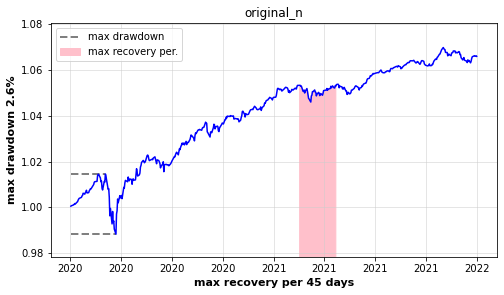

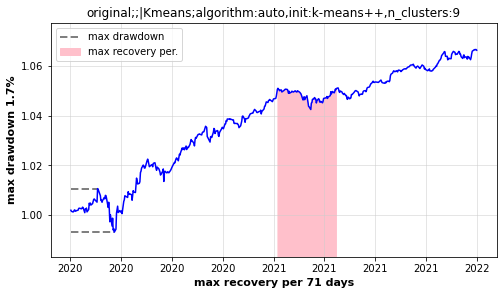

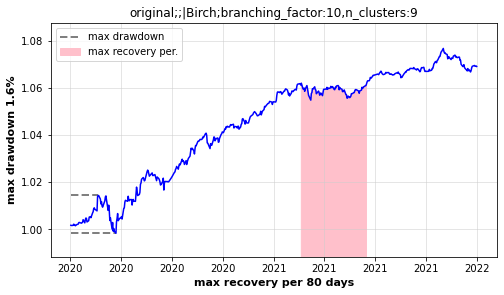

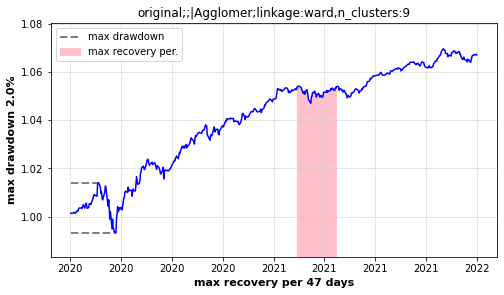

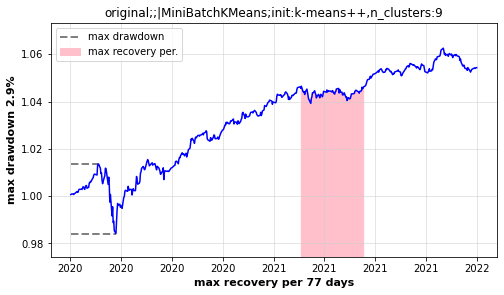

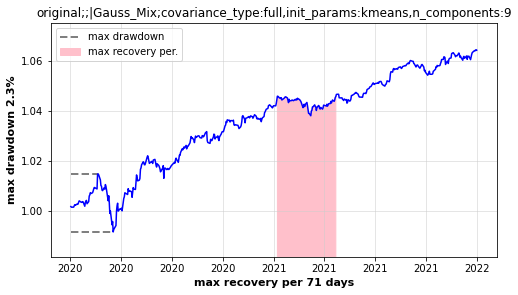

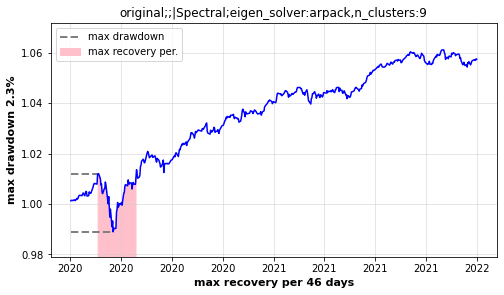

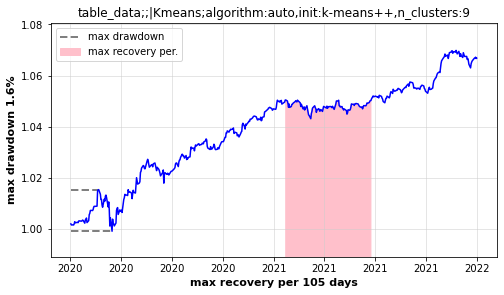

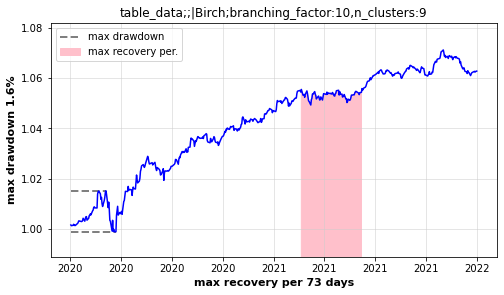

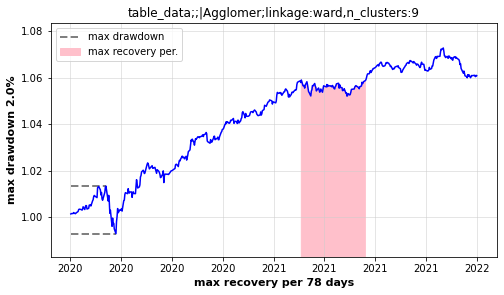

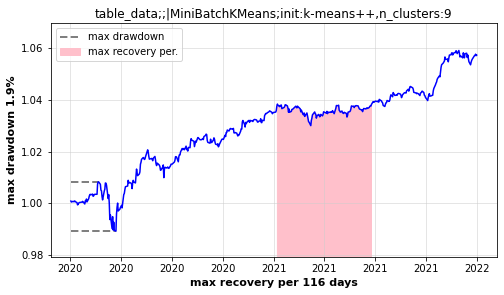

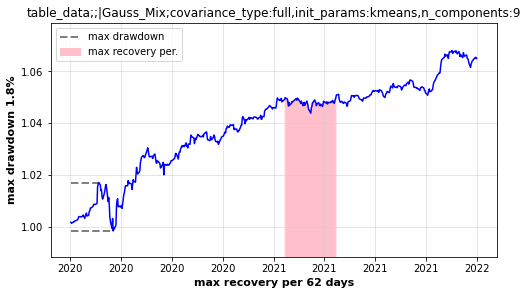

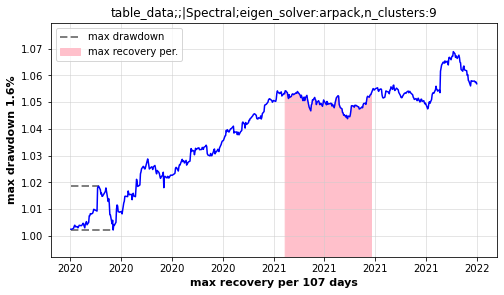

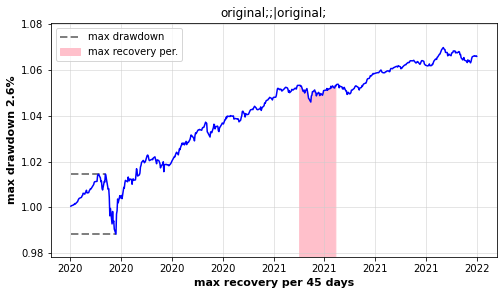

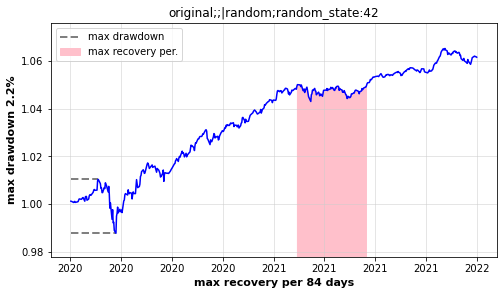

In [19]:
portfolios = time_ser_port.keys()

for label in portfolios:
    show_stats_of_stock(time_ser_port[label], label)